# Chapter 8

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
pip install pydicom

In [11]:
%matplotlib inline
import skimage
print(skimage.__version__)

import numpy as np
import PIL as pil

from PIL import Image, ImageFont, ImageDraw
from PIL.ImageChops import add, subtract, multiply, difference, screen
import PIL.ImageStat as stat

from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
from skimage import color, viewer, exposure, img_as_float, data
from skimage.transform import SimilarityTransform, warp, swirl
from skimage.util import invert, random_noise, montage

from skimage import viewer
from skimage.viewer import ImageViewer
# https://scikit-image.org/docs/dev/user_guide/viewer.html

import skimage as skim
import skimage.io as skim_io
import skimage.transform as skim_tr
import skimage.util as skim_ut

import matplotlib.image as mpimg
import matplotlib.pylab as plt

from scipy.ndimage import affine_transform, zoom
from scipy import misc
import scipy.ndimage
import scipy 

0.16.2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Viewer requires Qt
  del sys.path[0]


In [12]:
!pip install scipy
!pip install "scipy==1.1.0"

#### Segmentation

thresh_otsu 151
thresh_yen 140


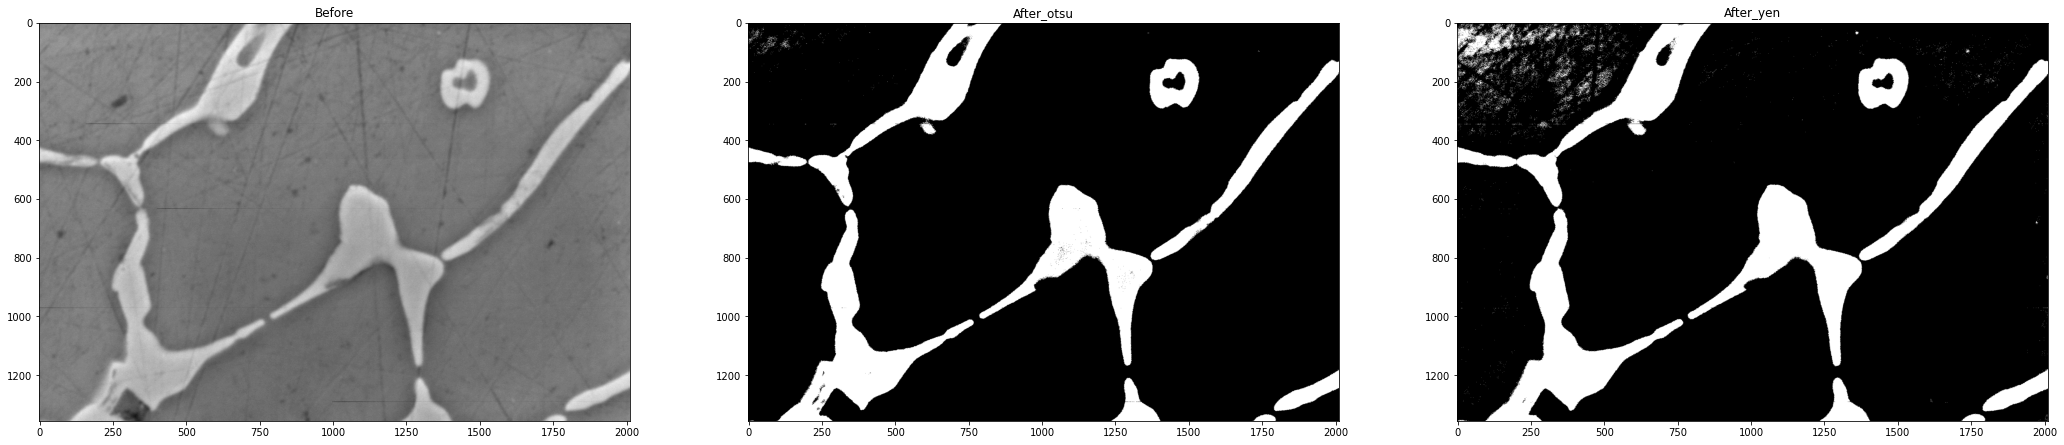

In [105]:
import cv2
import numpy
from PIL import Image 
from skimage.filters.thresholding import threshold_otsu
from skimage import data,filters
import matplotlib.pyplot as plt



# Opening the image and converting it to grayscale
a = Image.open('/content/drive/MyDrive/DIP colab/sem3.png').convert('L')
a = numpy.asarray(a)

thresh = threshold_otsu(a)
thresh1 = filters.threshold_yen(a) 
print('thresh_otsu',thresh)
print('thresh_yen',thresh1)
# Pixels with intensity greater than the
# "threshold" are kept.
b = 255*(a > thresh)
c = 255*(a > thresh1)
# Saving the image.
fig = plt.figure(figsize=(36, 36))
ax = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(a, cmap='gray')
ax.set_title('Before')
ax = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(b, cmap='gray')
ax.set_title('After_otsu')
ax = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(c, cmap='gray')
ax.set_title('After_yen')
plt.show()

#### Renyi Entropy

The renyi threshold is:  61


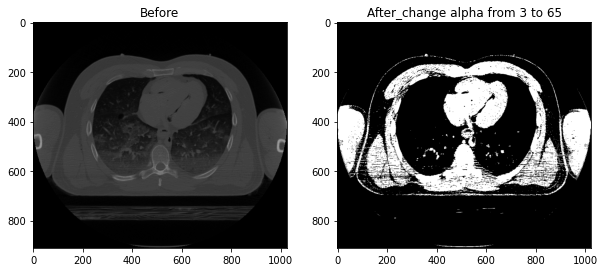

In [110]:
import cv2
from PIL import Image
import numpy as np
import skimage.exposure as imexp
import matplotlib.pyplot as plt

# Defining function
def renyi_seg_fn(im, alpha):
    hist, _ = imexp.histogram(im)
    # Convert all values to float
    hist_float = np.array([float(i) for i in hist])
    # compute the pdf
    pdf = hist_float/np.sum(hist_float)
    # compute the cdf
    cumsum_pdf = np.cumsum(pdf)
    s, e = im.min(), im.max()
    scalar = 1.0/(1.0-alpha)
    # A very small value to prevent error due to log(0).
    eps = np.spacing(1)

    rr = e-s
    # The inner parentheses is needed because
    # the parameters are tuple.
    h1 = np.zeros((rr, 1))
    h2 = np.zeros((rr, 1))
    # The following loop computes h1 and h2
    # values used to compute the entropy.
    for ii in range(1, rr):
        iidash = ii+s
        temp0 = pdf[0:iidash]/(cumsum_pdf[iidash])
        temp1 = np.power(temp0, alpha)
        h1[ii] = np.log(np.sum(temp1)+eps)
        temp0 = pdf[iidash+1:e]/(1.0-cumsum_pdf[iidash])
        temp2 = np.power(temp0, alpha)
        h2[ii] = np.log(np.sum(temp2)+eps)

    T = h1+h2
    # Entropy value is calculated
    T = T*scalar
    T = T.reshape((rr, 1))[:-2]
    # location where the maximum entropy
    # occurs is the threshold for the renyi entropy
    thresh = T.argmax(axis=0)
    return thresh


# Main program
# Opening the image and converting it to grayscale.
a = Image.open('/content/drive/MyDrive/DIP colab/CT.png').convert('L')
a = np.array(a)
# Computing the threshold by calling the function.
thresh = renyi_seg_fn(a, 65)
print('The renyi threshold is: ', thresh[0])
b = 255*(a > thresh)
# Saving the image as renyi_output.png
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(a, cmap='gray')
ax.set_title('Before')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(b, cmap='gray')
ax.set_title('After_change alpha from 3 to 65')
plt.show()



#### Adaptive Thresholding

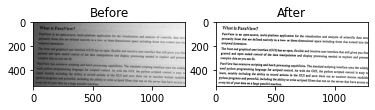

In [91]:
import cv2
import numpy
from PIL import Image
from skimage.filters import threshold_local
import matplotlib.pyplot as plt


# Opening the image and converting it to grayscale.
a = Image.open('/content/drive/MyDrive/DIP colab/adaptive_example1.png'). \
	convert('L')
a = numpy.asarray(a)
# Performing adaptive thresholding. 
b = cv2.adaptiveThreshold(a,a.max(),\
	cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY,21,10)
# Saving the image as adaptive_output.png 
# in the folder Figures. 
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(a, cmap='gray')
ax.set_title('Before')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(b, cmap='gray')
ax.set_title('After')
plt.show()

#### Watershed Segmentation

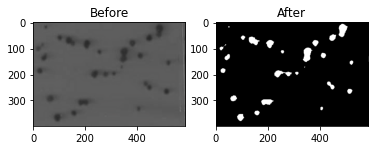

In [96]:
import cv2
from scipy.ndimage import label
import matplotlib.pyplot as plt


# Opening the image.
a = cv2.imread('/content/drive/MyDrive/DIP colab/cellimage.png')
# Converting to grayscale.
a1 = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
# Thresholding the image to obtain cell pixels.
thresh,b1 = cv2.threshold(a1, 0, 255,
            cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# Since Otsu's method has over segmented the image
# erosion operation is performed.
b2 = cv2.erode(b1, None,iterations = 2)
# Distance transform is performed
dist_trans = cv2.distanceTransform(b2, 2, 3)
# Thresholding the distance transform image to obtain 
# pixels that are foreground.
thresh, dt = cv2.threshold(dist_trans, 1, 
             255, cv2.THRESH_BINARY)	
# Performing labeling.
labelled, ncc = label(dt)
# Performing watershed.
cv2.watershed(a, labelled)
# Saving the image as watershed_output.png
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(a, cmap='gray')
ax.set_title('Before')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(b2, cmap='gray')#change b to b2
ax.set_title('After')
plt.show()

#### Chan-Vese Segmentation

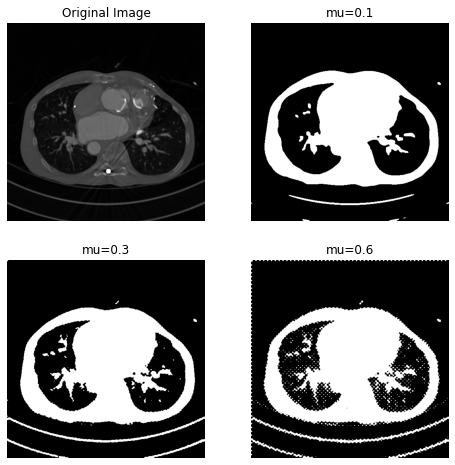

In [111]:
from PIL import Image
import matplotlib.pyplot as plt
from skimage.segmentation import chan_vese
import numpy as np
import matplotlib.pyplot as plt

# Opening the image and converting it into grayscale
img = Image.open('/content/drive/MyDrive/DIP colab/imageinverse_input.png').convert('L')
img = np.array(img)

cv1 = chan_vese(img, mu=0.1)
cv2 = chan_vese(img, mu=0.3)
cv3 = chan_vese(img, mu=0.6)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()
ax[0].imshow(img, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv1, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("mu=0.1", fontsize=12)

ax[2].imshow(cv2, cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("mu=0.3", fontsize=12)


ax[3].imshow(cv3, cmap="gray")
ax[3].set_axis_off()
ax[3].set_title("mu=0.6", fontsize=12)
#plt.imshow(img)
plt.show()